In [1120]:
import glob
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt

import cv2



In [1121]:
def set_axis(x: np.ndarray, no_labels: int = 7)->tuple[np.ndarray, np.ndarray]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

def automedian(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
    img_O = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_CO = cv2.morphologyEx(img_O, cv2.MORPH_CLOSE, struct)
    img_OCO = cv2.morphologyEx(img_CO, cv2.MORPH_OPEN, struct)

    img_C = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_OC = cv2.morphologyEx(img_C, cv2.MORPH_OPEN, struct)
    img_COC = cv2.morphologyEx(img_OC, cv2.MORPH_CLOSE, struct)
    img_Q = np.minimum(img, img_COC)

    img_A = np.maximum(img_Q, img_OCO)

    return img_A

def plt_imshow(df: pd.DataFrame, lines=None, norm=None):
    aspect_ratio = df.shape[1] / df.shape[0]
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    cax = fig.add_axes((ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height))
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    im = ax.imshow(df,interpolation='none',aspect='auto', norm=norm)
    plt.colorbar(im, cax=cax)

    plt.ylabel('time')
    plt.xlabel('space [m]') 
    if lines is not None:
        height, width = df.shape
        # for l in lines:
        #     rho = l[0][0]
        #     theta = l[0][1]
        #     a = np.cos(theta)
        #     b = np.sin(theta)
        #     x0 = a * rho
        #     y0 = b * rho
        #     # Points far outside image bounds for visualization
        #     x1 = np.clip(x0 + 2000*(-b), 0, width-1)
        #     y1 = np.clip(y0 + 2000*(a), 0, height-1)
        #     x2 = np.clip(x0 - 2000*(-b), 0, width-1)
        #     y2 = np.clip(y0 - 2000*(a), 0, height-1)
        #     # Plot lines on axes (swap x/y if needed for image orientation)
        #     ax.plot([x1, x2], [y1, y2], color='red', linewidth=1)
    if lines is not None:
        for l in lines:
            rho = l[0][0]
            theta = l[0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            # Compute endpoints at left and right borders
            x0 = 0
            y0 = (rho - x0 * a) / b if abs(b) > 1e-6 else 0
            x1 = width
            y1 = (rho - x1 * a) / b if abs(b) > 1e-6 else height
            # Only plot segments inside image
            ax.plot([x0, x1], [y0, y1], color='red', linewidth=1)

In [1122]:
path_out = 'train_data/'
files = glob.glob(path_out+"*")
files.sort()

In [1123]:
dx = 5.106500953873407
dt = 0.0016

data = []
my_first_filename = 'train_data/091222.npy'
first_id = 0
for idx, filename in enumerate(files):
    if filename == my_first_filename:
        first_id = idx
first_filename = files[first_id]
for file in files[first_id:first_id+12]:
    data.append(np.load(file))
data = np.concatenate(data).astype(np.float32)
time_start = datetime.datetime.strptime(
    '2024-05-07 ' + first_filename.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

columns = np.arange(len(data[0])) * dx

base_df = pd.DataFrame(data=data, index=index, columns=columns)



In [1124]:
def plot_fft(df, col_id, dt, xlim=300):
    """Plot FFT spectrum at a spatial position."""
    spatial_pos = df.columns[col_id] 
    signal = df[spatial_pos].values
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)
    pos_freqs = fft_freqs[:len(signal)//2]
    pos_mags = np.abs(fft_result[:len(signal)//2])
    plt.plot(pos_freqs, pos_mags)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency spectrum at {spatial_pos:.1f} m')
    plt.xlim(0, xlim)
    xticks = np.arange(0, xlim+10, 10)
    plt.xticks(xticks)
    plt.xticks(rotation=-90)
    plt.show()

def plot_average_freq_spectrum(filtered_df, dt, col_start=None, col_end=None):
    """
    Plots the average frequency spectrum over selected spatial columns.
    
    Parameters:
      filtered_df: pandas DataFrame, rows=time, cols=space
      dt: time step (seconds)
      col_start: first column index to include (inclusive)
      col_end: last column index to include (exclusive)
      title: custom plot title (optional)
      xlim: x-axis frequency limit for plot (optional, tuple)
    """
    avg_signal = filtered_df.iloc[:, col_start:col_end].mean(axis=1).values
    fft_result = np.fft.fft(avg_signal)
    fft_freqs = np.fft.fftfreq(len(avg_signal), d=dt)
    positive_freqs = fft_freqs[:len(avg_signal)//2]
    positive_mags = np.abs(fft_result[:len(avg_signal)//2])
    
    plt.plot(positive_freqs, positive_mags)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    title_substring = "all" if col_start is None or col_end is None else f"{col_start} to {col_end-1}"
    plt.title(f"Average Frequency Spectrum for columns: {title_substring}")

    plt.show()

#https://www.geeksforgeeks.org/data-science/signal-filtering-with-scipy/
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def filter_df_combine_bands(df, bands, dt, order=4):
    """
    Filter a DataFrame so that only the given bands are present (sum their filters).
    bands: list of (low, high) frequency tuples
    Returns: a DataFrame containing the sum of all filtered bands.
    """
    fs = 1 / dt
    result = np.zeros_like(df.to_numpy())
    for low, high in bands:
        filtered = df.apply(lambda col: butter_bandpass_filter(col.values, low, high, fs, order), axis=0)
        result += filtered.to_numpy()
    return pd.DataFrame(result, index=df.index, columns=df.columns)

def filter_df_band(df, low, high, dt, order=4):
    fs = 1 / dt
    return df.apply(lambda col: butter_bandpass_filter(col.values, low, high, fs, order), axis=0)

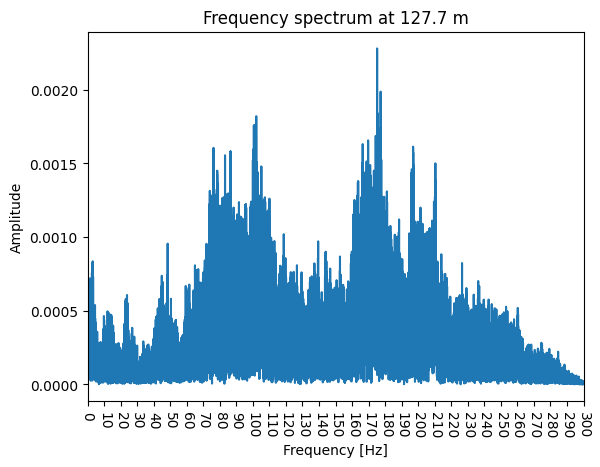

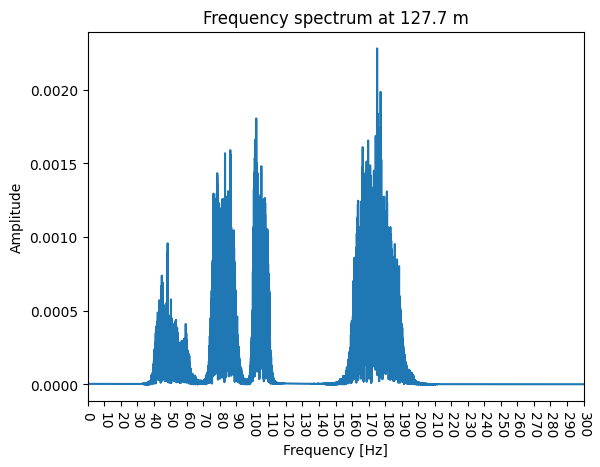

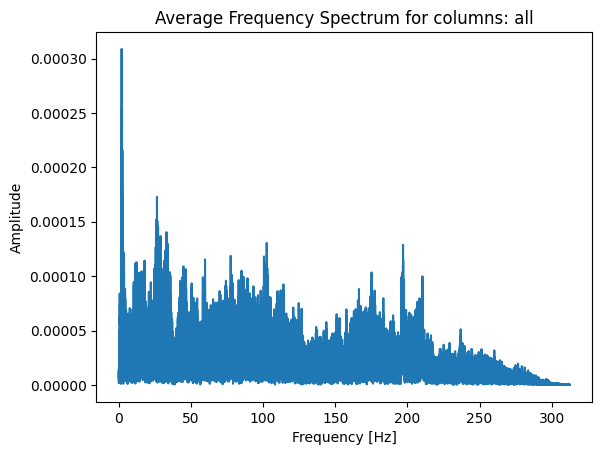

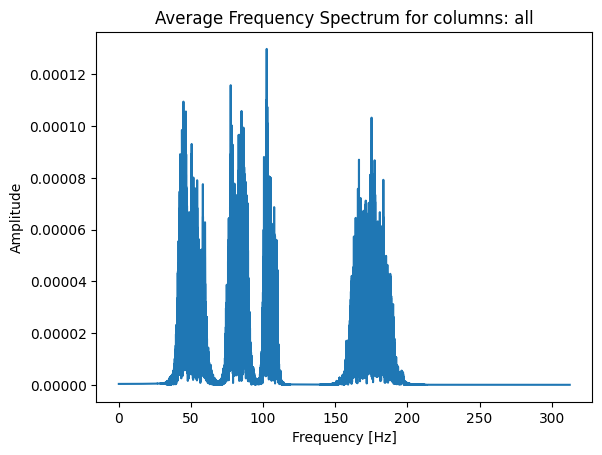

In [1125]:
col_id = 25

bands = [(40, 60), (75, 90), (100, 110),(160, 190)]
# bands=[(5, 220)]
# base_df -= base_df.mean()
# base_df = np.abs(base_df)
filtered_df = filter_df_combine_bands(base_df, bands, dt)

plot_fft(base_df, col_id, dt)
plot_fft(filtered_df, col_id, dt)
plot_average_freq_spectrum(base_df, dt)
plot_average_freq_spectrum(filtered_df, dt)



In [1126]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    # df = df.iloc[::10, :]  # Every 10th time sample, all columns
    df = df.resample('0.16S').median()
    print(df.shape)
    data = df.to_numpy(dtype=np.float32)
    data = (data - data.mean()) / data.std()
    # data = cv2.resize(data, dsize=(52, 750), interpolation=cv2.INTER_AREA)
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # data = cv2.equalizeHist(data)
    clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))
    data = clahe.apply(data)
    data = cv2.bilateralFilter(data, 9, 75, 75) #https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
    # data = cv2.GaussianBlur(data,(5,5),cv2.BORDER_DEFAULT)
    processed_df = pd.DataFrame(data, index=df.index, columns=df.columns)
    return processed_df

def find_edges_canny(df: pd.DataFrame) -> pd.DataFrame:
    data = df.to_numpy(dtype=np.uint8)

    plt.imshow(data, aspect='auto')
    edges = cv2.Canny(data, 20,50, None)
    # edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    # edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    return edges

base_df -= base_df.mean()
base_df = np.abs(base_df)

filtered_df -= filtered_df.mean()
filtered_df = np.abs(filtered_df)

dfs = [base_df, filtered_df]
pp_dfs = [preprocess_df(df) for df in dfs]
all_dfs = dfs + pp_dfs

norms = []
for df in all_dfs:
    low, high = np.percentile(df, [3, 99])
    norms.append(Normalize(vmin=low, vmax=high, clip=True))





/tmp/ipykernel_8117/271939180.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('0.16S').median()
/tmp/ipykernel_8117/271939180.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('0.16S').median()


(751, 52)
(751, 52)


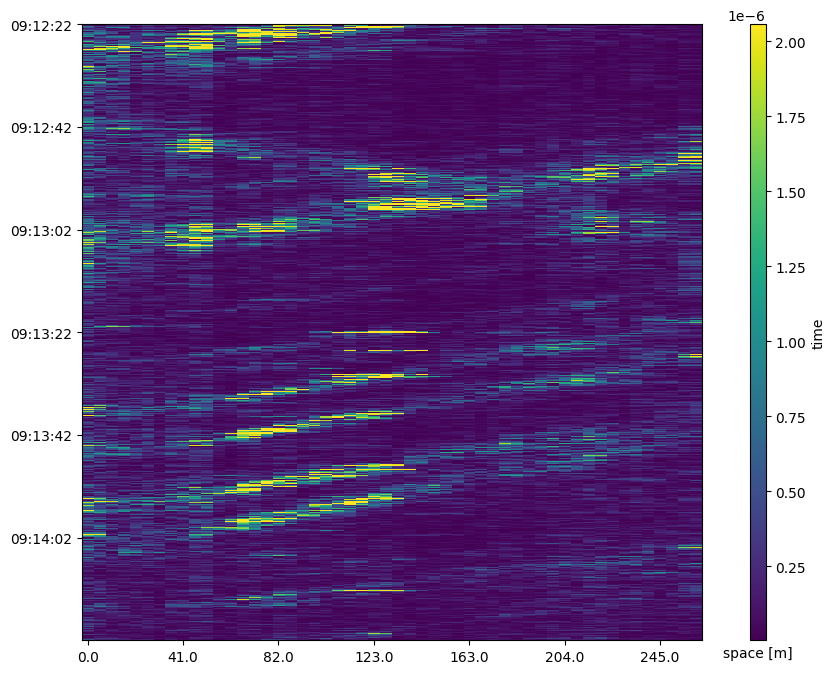

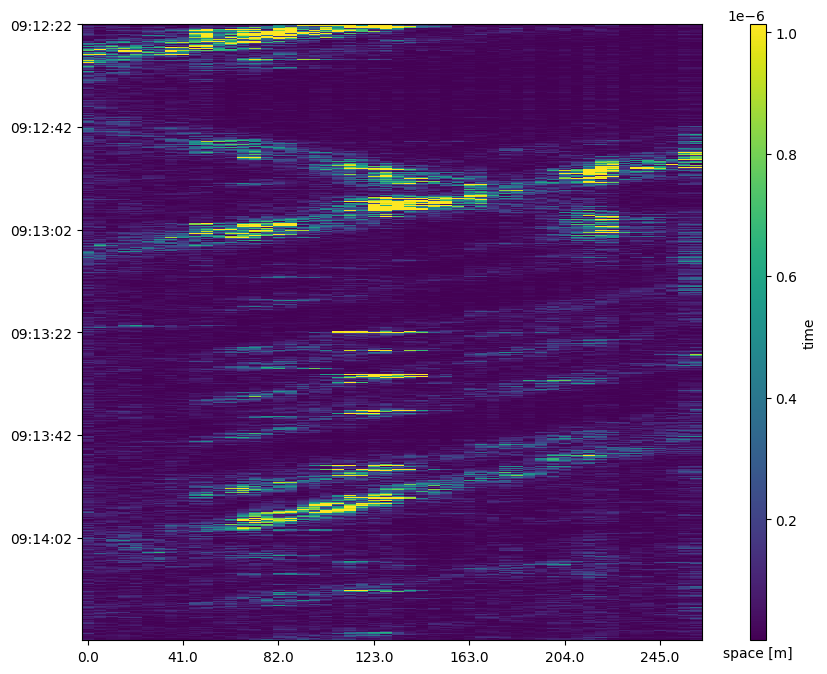

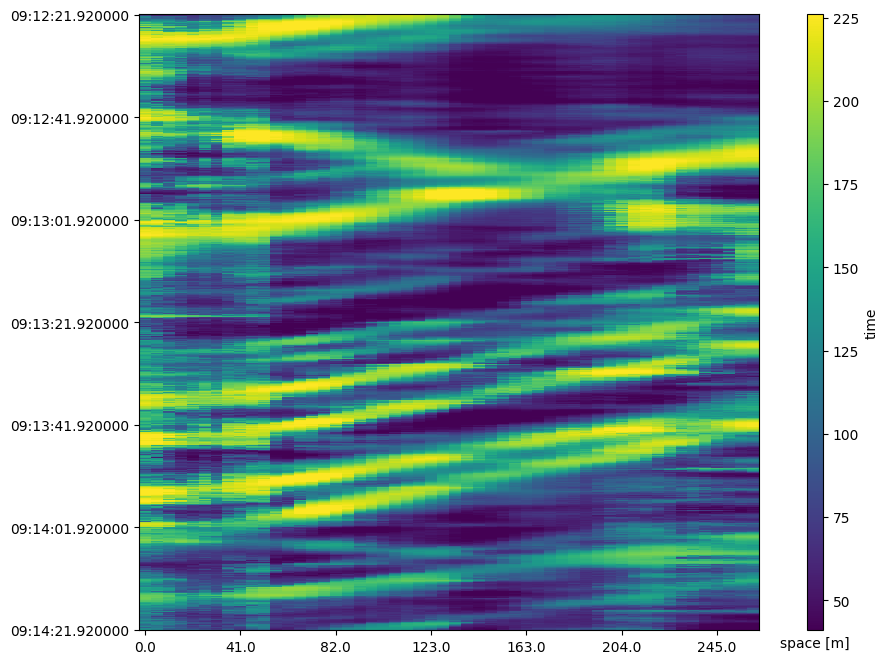

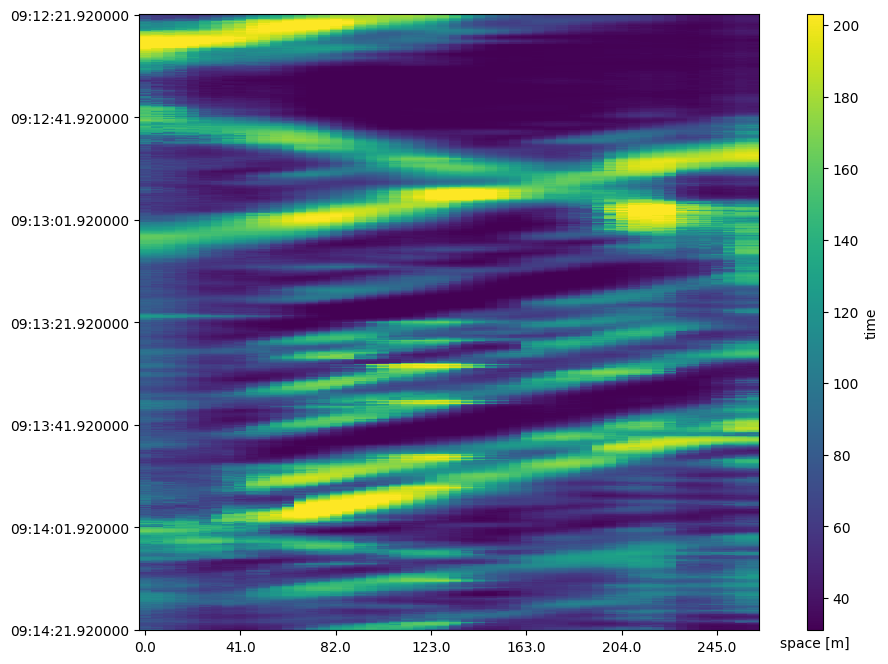

In [1127]:
for df, norm in zip(all_dfs, norms):
    plt_imshow(df, lines=None, norm=norm)

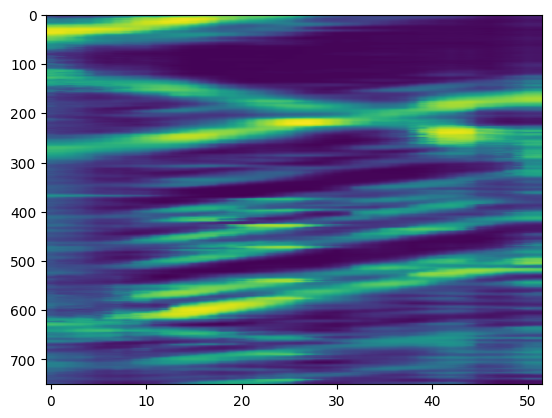

In [1128]:
edges = find_edges_canny(pp_dfs[1])
lines = cv2.HoughLinesP(
    edges,           # edge image
    rho=1,           # distance resolution in pixels
    theta=np.pi/180,  # angle resolution in radians
    threshold=50,    # minimum number of intersecting points to detect a line
    minLineLength=30,  # minimum length of line (in pixels)
    maxLineGap=10    # maximum allowed gap between line segments to treat them as one line
)

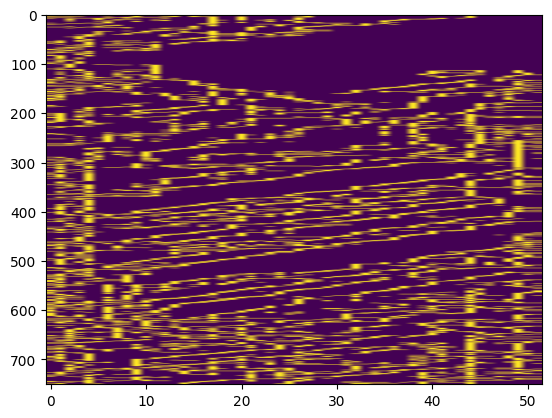

In [1129]:
plt.imshow(edges, aspect='auto')


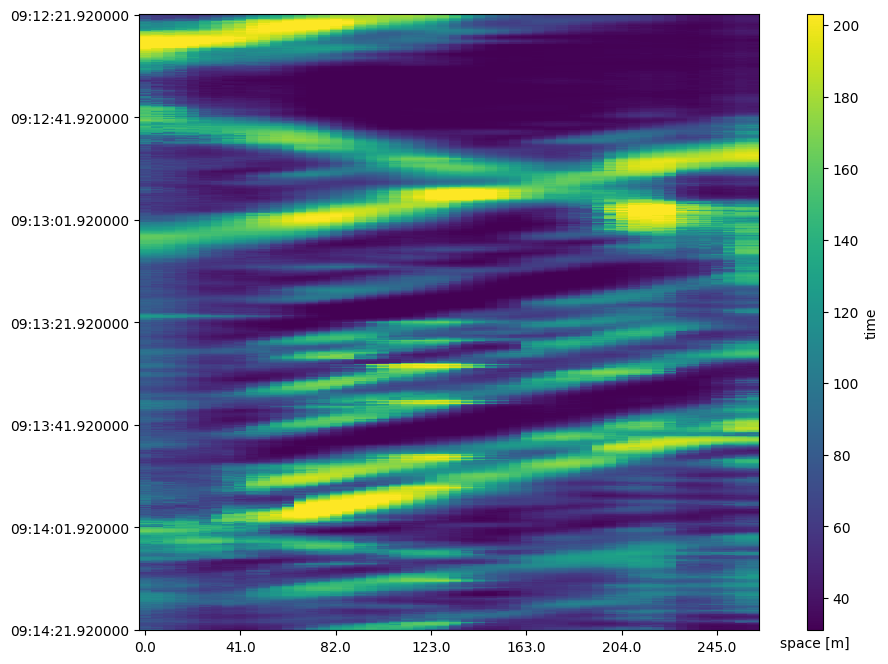

In [1130]:
plt_imshow(pp_dfs[1], lines=None, norm=norms[3])
# plt.imshow(lines)

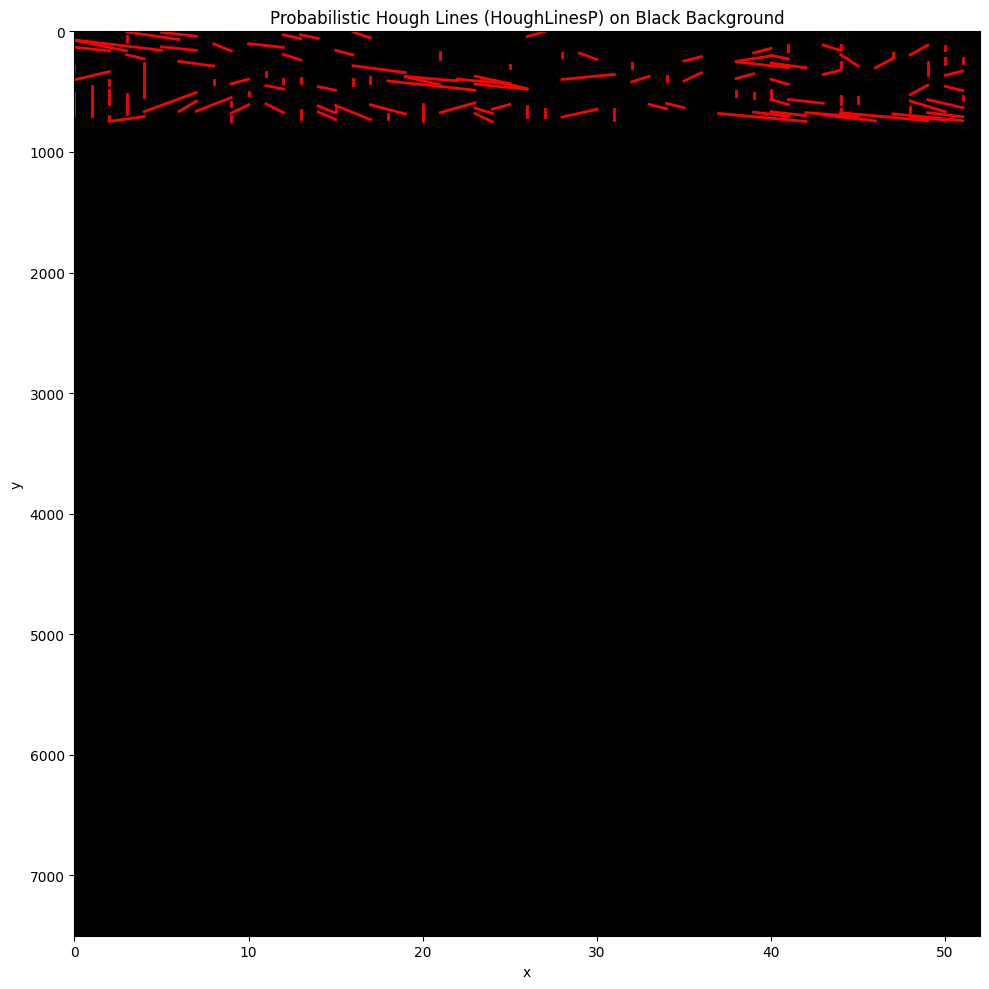

In [1131]:

def plot_hough_linesP_on_black(lines, shape=(7500, 52), color='red', linewidth=2):
    """
    Plots probabilistic Hough lines (cv2.HoughLinesP output) on a black background.

    Args:
        linesP: result of cv2.HoughLinesP, each line is [[x1, y1, x2, y2]]
        shape: tuple (height, width) of canvas
        color: line color (default 'red')
        linewidth: line thickness
    """
    height, width = shape
    plt.figure(figsize=(10, 10))  # Tall figure for tall, narrow shape
    ax = plt.gca()
    ax.set_facecolor('black')  # set background to black
    plt.xlim(0, width)
    plt.ylim(height, 0)        # Origin at top-left

    # Draw each line segment
    if lines is not None:
        for l in lines:
            x1, y1, x2, y2 = l[0]
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Probabilistic Hough Lines (HoughLinesP) on Black Background')
    plt.tight_layout()
    plt.show()

# Example usage:
# lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
plot_hough_linesP_on_black(lines, shape=(7500, 52))

In [1132]:
#https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv possibly interesting
# https://docs.opencv.org/3.2.0/d1/dee/tutorial_moprh_lines_detection.html